# Week 7 - Neural Networks
Today, we will build a neural network to classify breast cancer images.  This type of neural network is call a 'Convolutional Neural Network' (CNN), and is the most common machine learning (ML) approach to image classification. 


Our goal is to build a classifier capable of predicting lesion type. It will be supplied a breast tissue image from a patient, and will need to identify the type of lesion seen. Here, lesion refers to a type of abnormal growth seen in breast tissue images. Each image will be classified to one of these lesions. Our lesions (classifications) are:

(benign)
* adenosis 
* fibroadenoma 
* phyllodes_tumor 
* tubular_adenoma 

(malignant)
* ductal_carcinoma 
* lobular_carcinom 
* mucinous_carcinoma 
* papillary_carcinoma 


We want our CNN to be accurate as possible. This is highly important when providing diagnosis, as some of the lesions are benign, while others are malignant and indicate cancerous growth. 

Let's import and have a look at the data! The cell below clones the github repository as usual. Our labelled breast tissue images are there.


In [1]:
!git clone https://github.com/adamtaranto/COMP90014_2021.git

Cloning into 'COMP90014'...
remote: Enumerating objects: 2119, done.
remote: Counting objects: 100% (2119/2119), done.
remote: Compressing objects: 100% (2098/2098), done.
remote: Total 2119 (delta 32), reused 2105 (delta 18), pack-reused 0
Receiving objects: 100% (2119/2119), 41.82 MiB | 22.81 MiB/s, done.
Resolving deltas: 100% (32/32), done.


The first job is to look at the data. We want to know if there are discernible features between our lesion types, and what possible sources of bias there are in our data. Run the cell below to display a group of sample images.

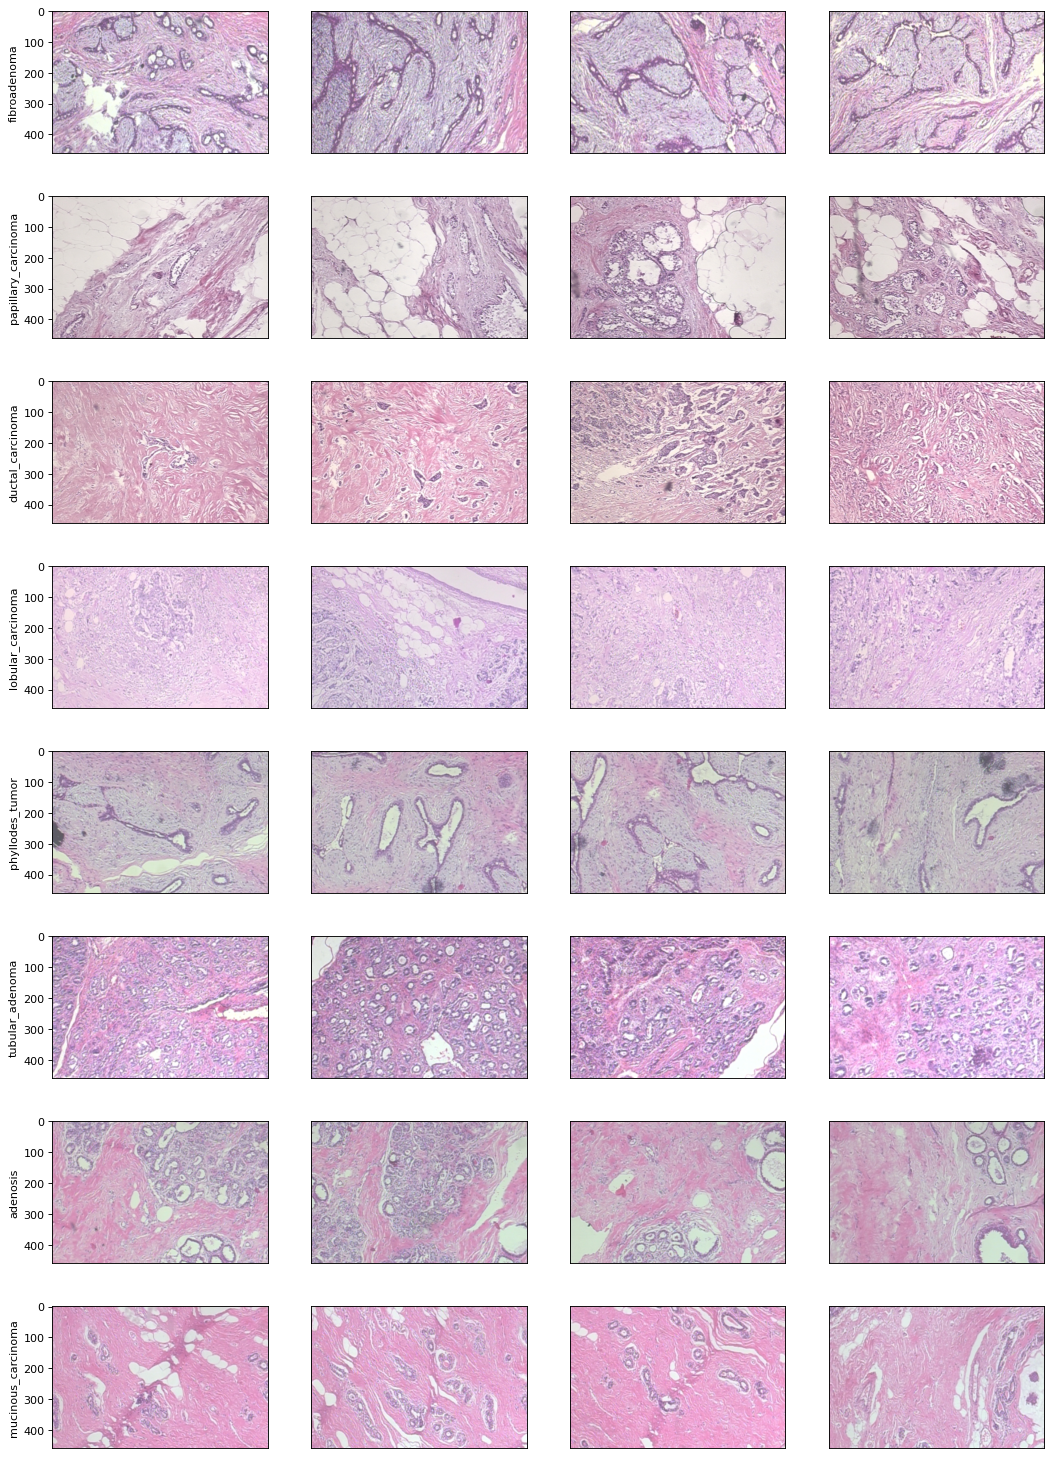

In [100]:
import os
import matplotlib.pyplot as plt 
from matplotlib.image import imread
%matplotlib inline

base_folder = 'COMP90014/data/breast_cancer_sample_images/'
lesion_folders = os.listdir(base_folder)

lesions_images = {}
for lesion_type in lesion_folders:
  sample_images = os.listdir(base_folder + lesion_type)
  sample_images = [filename for filename in sample_images if '.png' in filename]
  lesions_images[lesion_type] = sample_images

xdim = 4
ydim = 8

fig, axes = plt.subplots(ydim, xdim, figsize=(16, 24), dpi=80)
for j, lesion_type in enumerate(lesions_images):
    lesion_type_images = lesions_images[lesion_type]
    for i in range(xdim):
        image = imread(base_folder + lesion_type + '/' + lesion_type_images[i])
        axes[j, i].imshow(image)
        axes[j, i].axes.xaxis.set_visible(False)
        axes[j, i].axes.yaxis.set_visible(False)
    axes[j, 0].set_ylabel(lesion_type)
    axes[j, 0].axes.yaxis.set_visible(True)

plt.show()


There are some obvious feature (histology) differences between the lesion types. We should be able to create a model with reasonable accuracy, given we handle the data correctly.   



---


**First task**<br>
Think about the possible sources of bias in this data. For reference, the images were not all generated on the same microscope, but are the same magnification (40X). Additionally, the cell straining process does not always produce the same intensity of pigment depending on sample handling.


Time to install the versions of keras and tensorflow we need. Keras is a high-level API for tensorflow, and allows us to do quite complicated tasks in a single line. 

In [3]:
!pip install keras==2.3.1
!pip install tensorflow==2.0.0

     |████████████████████████████████| 378kB 3.4MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 86.3MB 106kB/s 
     |████████████████████████████████| 3.8MB 37.9MB/s 
     |████████████████████████████████| 450kB 42.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=43a523ba6a784190bc041bf3280674c5403c3db6bf9fa4d83a0170776b63999e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Suc

Imports

In [5]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


To properly train and test our model, the images need to be split into two groups. The 'train' group will contain images to train the network, and the 'test' group will be images the model has not seen before. These are to verify the performance of our model on new images. 


Look at the folder structure for our data. In the Files tab in the left hand panel, go to COMP90014 -> data -> breast_cancer_training. You will see that the images have been placed into folders by lesion type. This format allows us to import images and know their lesion label for training. 

The cell below will create an ImageDataGenerator. This will import our training images, nicely labelled and formatted for the network. It will additionally perform image augmentation to randomise the images we get.  

In [133]:
def preprocess_training():
    train_datagen = ImageDataGenerator(brightness_range=[0.95, 1.05], channel_shift_range=0.1, rotation_range=90, shear_range=0.1, zoom_range=0.1)
    training_set = train_datagen.flow_from_directory('COMP90014/data/breast_cancer_training', target_size=(70, 46), batch_size=16, class_mode='categorical', color_mode='grayscale')
    return training_set

In [134]:
training_set = preprocess_training()

Found 1511 images belonging to 8 classes.


The ImageDataGenerator will supply augmented images to our model for training. We add random permutations to the training images to account for a wider range of images which may be fed to the model after training. In this case, the brightness and saturation of the images is being altered, and images can be sheared, zoomed and rotated. The cell below will show how the images are being augmented

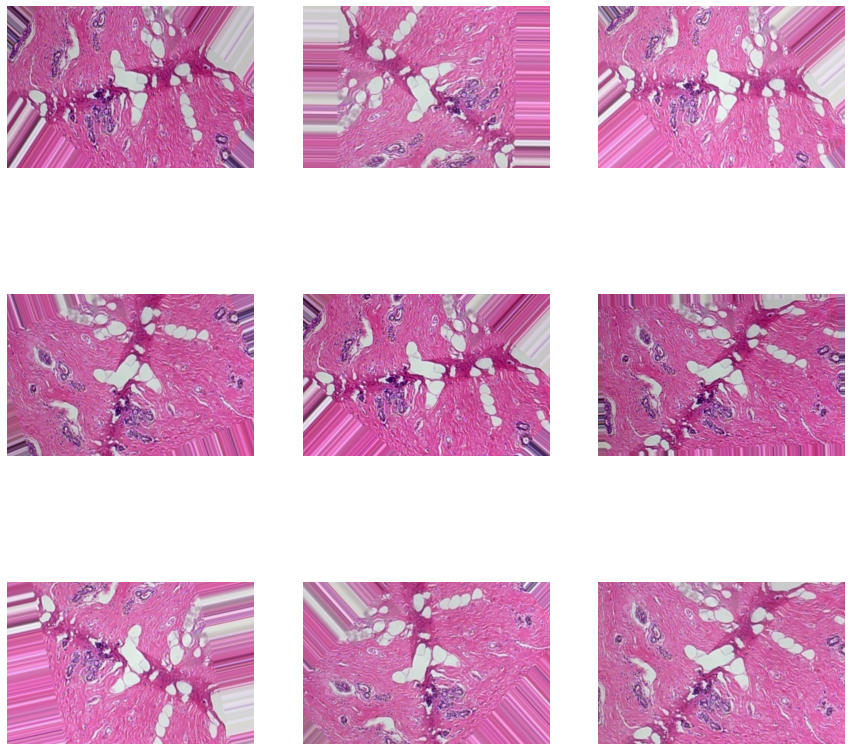

In [132]:
import numpy as np 
image = imread(base_folder + 'mucinous_carcinoma/' + lesions_images['mucinous_carcinoma'][0])
image = np.expand_dims(image, axis=0)
datagen = ImageDataGenerator(brightness_range=[0.95, 1.05], channel_shift_range=0.1, rotation_range=90, shear_range=0.1, zoom_range=0.1)
aug_iter = datagen.flow(image, batch_size=1)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
for i in range(3):
  for j in range(3):
    image = next(aug_iter)[0].astype('uint8')
    ax[i, j].imshow(image)
    ax[i, j].axis('off')

We also need to set up an object which flows in the test images. This will not include any augmentation. 

In [135]:
def preprocess_test():
    test_datagen = ImageDataGenerator()
    test_set = test_datagen.flow_from_directory('COMP90014/data/breast_cancer_test', target_size=(70, 46), batch_size=16, class_mode='categorical', color_mode='grayscale')
    return test_set

In [136]:
test_set = preprocess_test()

Found 484 images belonging to 8 classes.


## Designing our CNN
Now its time for the really fun stuff! Here we get to design our model architecture. 

The best architecture for a neural network is hard to define or guess. Sometimes the best course of action is try an idea, then explore many permutations of that idea. The model specified below uses 2 convolutional filters, 2 max pooling layers, then a dense neural network of 2 hidden layers. The last layer represents our classifications. Execute the two cells below to build and show a summary of our model.

In [144]:
def build_cnn_structure():
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[70, 46, 1]))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
    cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))
    cnn.add(tf.keras.layers.Dense(units=8, activation='sigmoid'))
    cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return cnn

In [145]:
cnn = build_cnn_structure()
cnn.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 68, 44, 16)        160       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 34, 22, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 20, 16)        2320      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 16, 10, 16)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 2560)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               327808    
_________________________________________________________________
dense_37 (Dense)             (None, 64)              

Notice the number of trainable parameters! Lots to optimise. 

If we think our approach is good, we would then try altering the number of feature layers, the number of layers in our dense neural network, the number of nodes in those layers etc. There are automated functions available in keras to explore the parameter space in this manner.  

Ok only thing to do now is train the model using our image data! We will do this in 'epochs' or batches, and at the end of each epoch we will check the accuracy of our model on the unseen test images. 

In [143]:
cnn.fit(x=training_set, validation_data=test_set, epochs=20)

Train for 95 steps, validate for 31 steps
Epoch 1/20
95/95 [==============================] - 6s 60ms/step - loss: 0.3423 - accuracy: 0.8733 - val_loss: 0.3512 - val_accuracy: 0.8750
Epoch 2/20
95/95 [==============================] - 6s 59ms/step - loss: 0.3443 - accuracy: 0.8724 - val_loss: 0.3336 - val_accuracy: 0.8742
Epoch 3/20
95/95 [==============================] - 6s 60ms/step - loss: 0.3418 - accuracy: 0.8724 - val_loss: 0.3407 - val_accuracy: 0.8750
Epoch 4/20
95/95 [==============================] - 6s 60ms/step - loss: 0.3362 - accuracy: 0.8744 - val_loss: 0.3443 - val_accuracy: 0.8750
Epoch 5/20
95/95 [==============================] - 6s 60ms/step - loss: 0.3339 - accuracy: 0.8730 - val_loss: 0.3490 - val_accuracy: 0.8750
Epoch 6/20
95/95 [==============================] - 6s 61ms/step - loss: 0.3340 - accuracy: 0.8738 - val_loss: 0.3650 - val_accuracy: 0.8750
Epoch 7/20
95/95 [==============================] - 6s 59ms/step - loss: 0.3354 - accuracy: 0.8752 - val_loss: 0

You may have heard that GPUs are important for machine learning. They enable us to train our models much faster than when using a CPU. Colab allows us to use a GPU for this hardware acceleration. 

The cell below checks whether we have access to a GPU at this time. If so, we can use the cell below that to perform GPU accelerated training of our model. 

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
with tf.device('/device:GPU:0'):
  cnn.fit(x=training_set, validation_data=test_set, epochs=100)

It is important to understand how the model is making its decisions. Image classification is all about features, and how they can be identified. The 4 cells below will print out a test image, and its representation as the data moves through our model. 

In [146]:
from keras.preprocessing import image 
from keras import models 
from keras import layers 

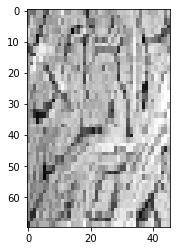

In [147]:
test_image = image.load_img('COMP90014/data/breast_cancer_test/fibroadenoma/SOB_B_F-14-14134-40-005.png', target_size = (70, 46), color_mode='grayscale')
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
plt.imshow(test_image[0,:,:,0], cmap='Greys_r') 
plt.show() 


In [148]:
# Outputs of the 8 layers, which include conv2D and max pooling layers 
layer_outputs = [layer.output for layer in cnn.layers] 
activation_model = tf.keras.models.Model(inputs = cnn.input, outputs = layer_outputs) 
activations = activation_model.predict(test_image) 



 ------------------------- LAYER 0 OUTPUT -------------------------------


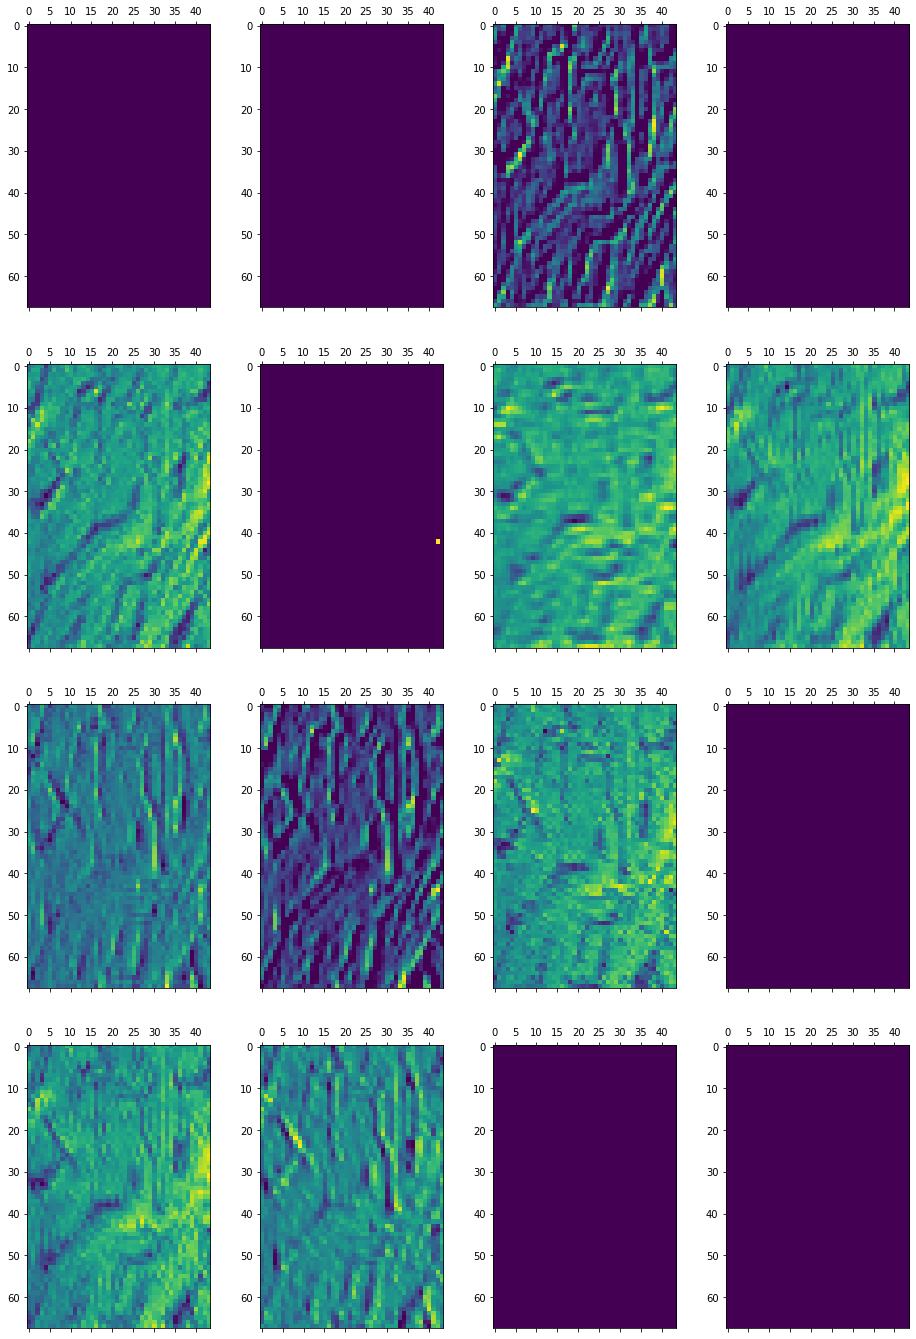



 ------------------------- LAYER 1 OUTPUT -------------------------------


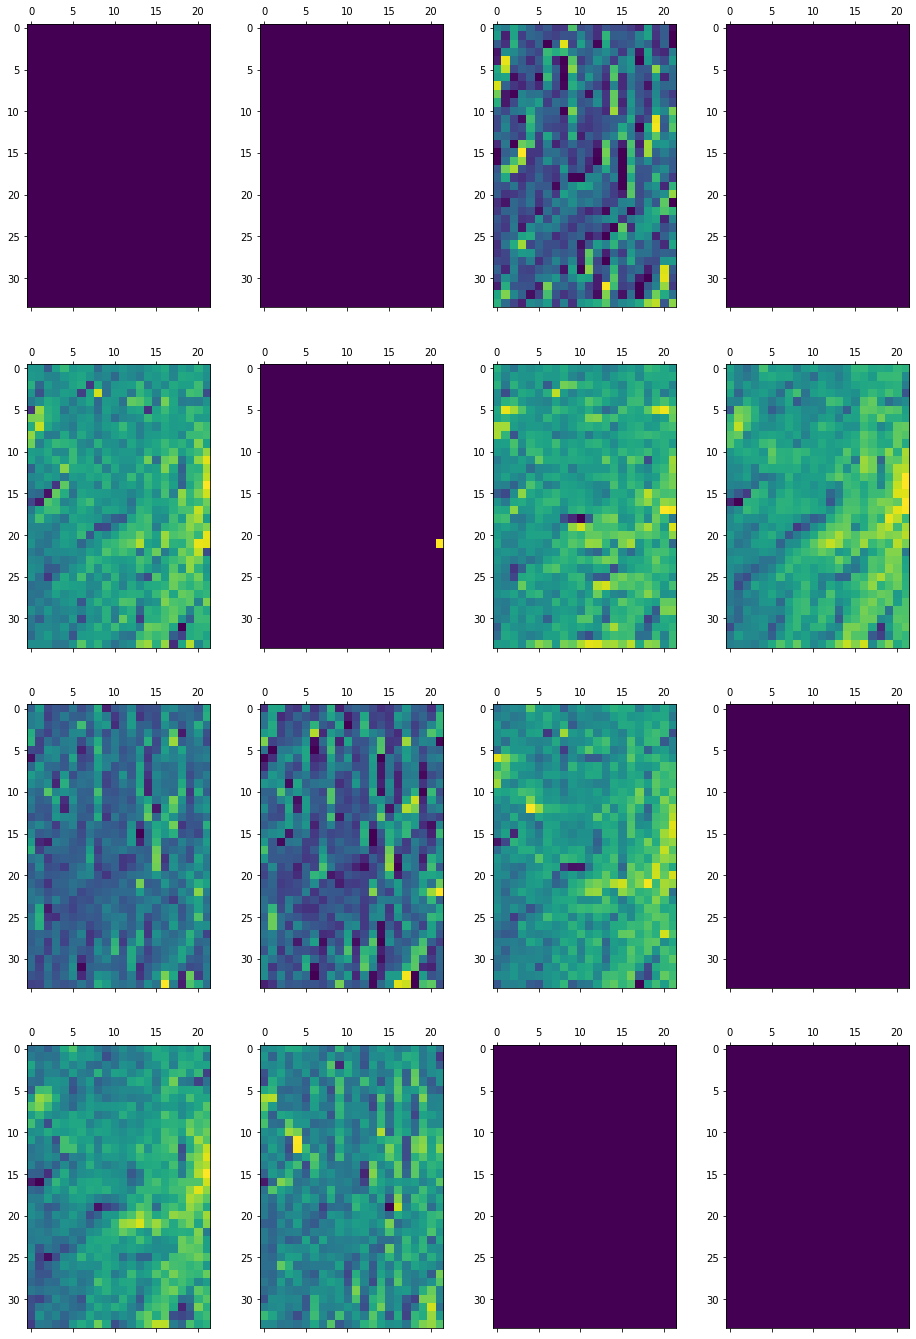



 ------------------------- LAYER 2 OUTPUT -------------------------------


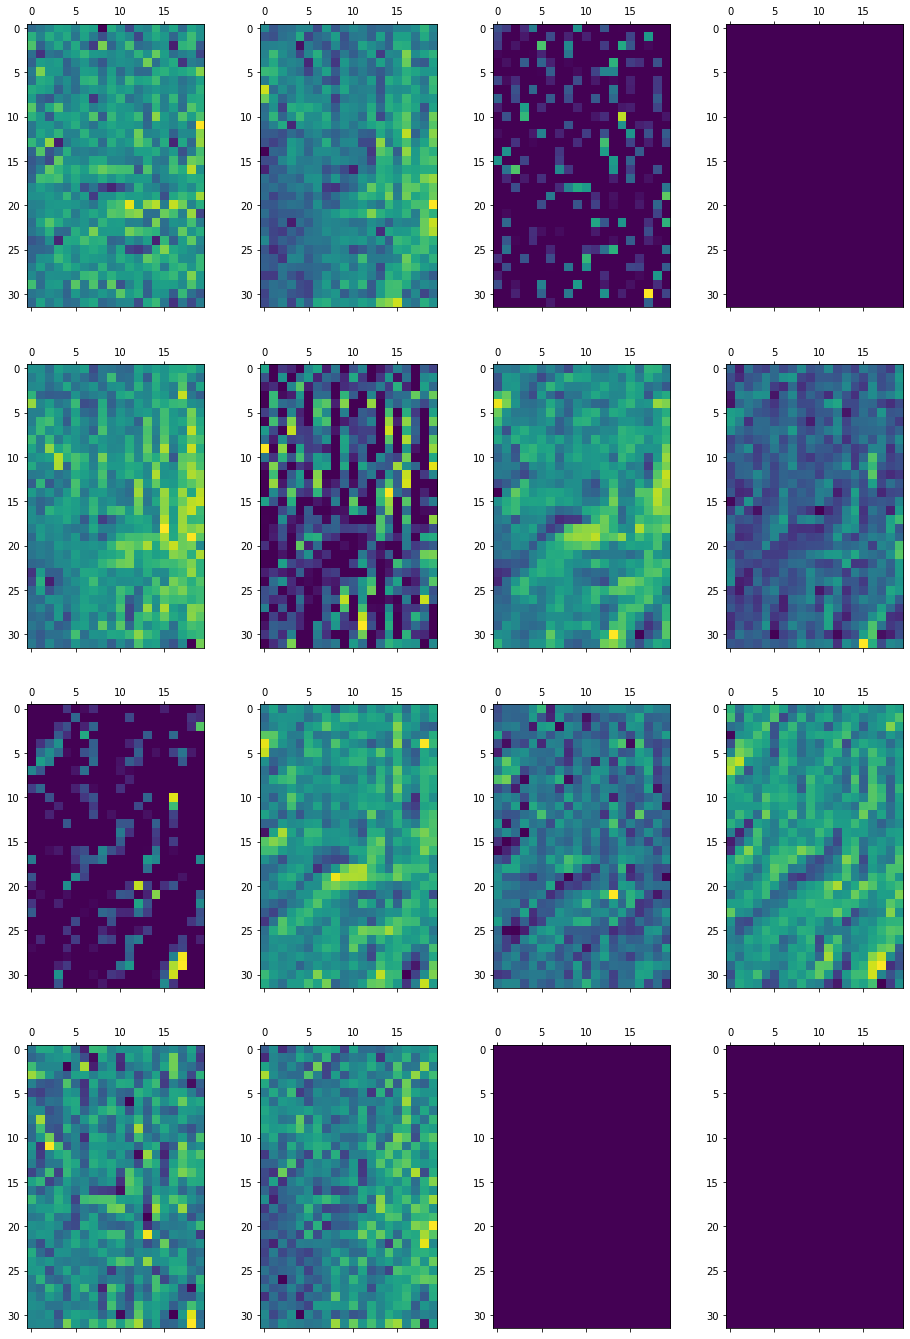



 ------------------------- LAYER 3 OUTPUT -------------------------------


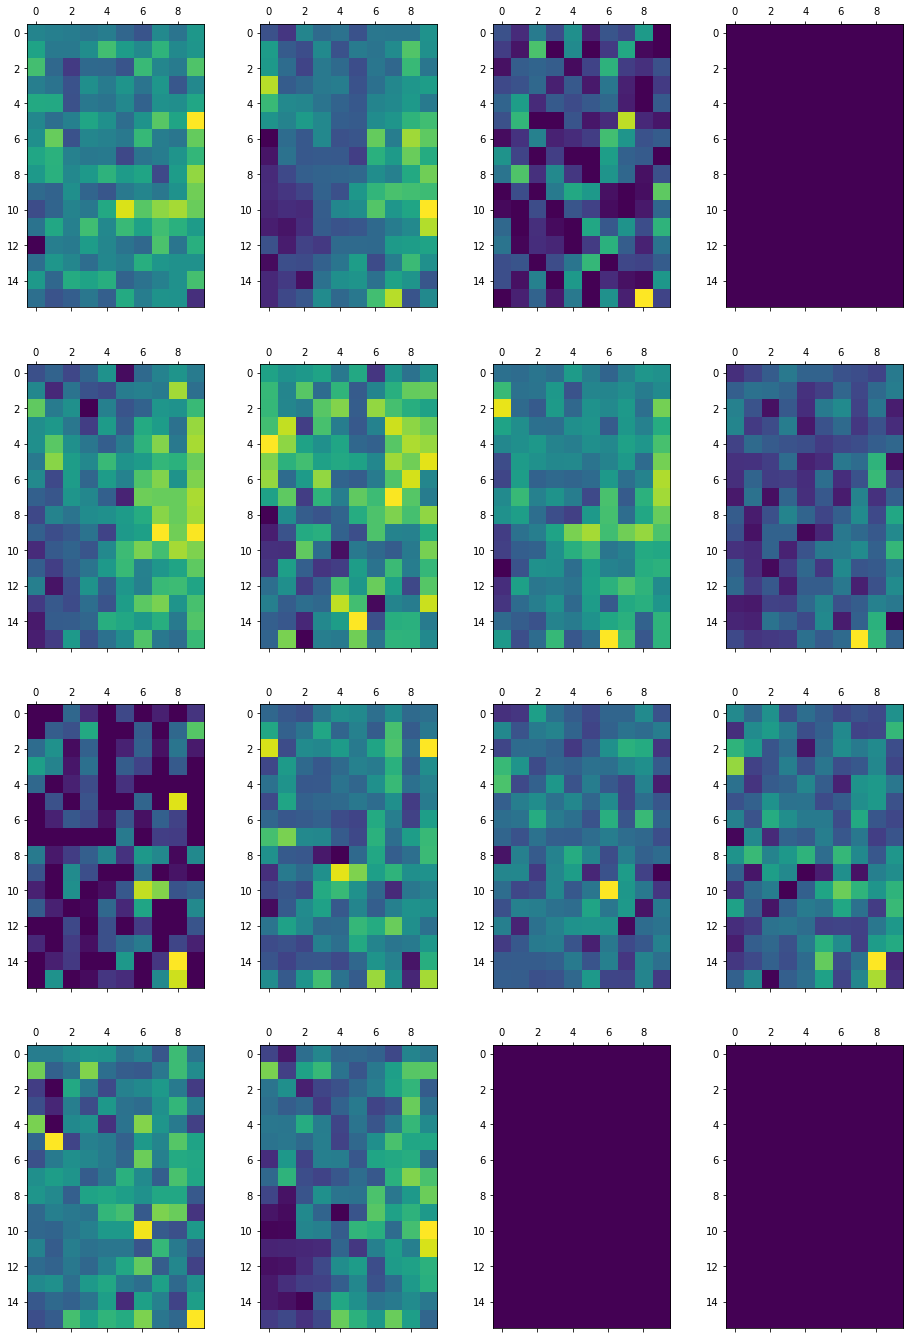

In [149]:
# Get ready for some plots lol

for i in range(4):
  print(f'\n\n ------------------------- LAYER {i} OUTPUT -------------------------------')

  layer_activation = activations[i] 
  fig, axes = plt.subplots(4, 4, figsize=(16, 24))
  for j in range(4):
    for k in range(4):
      # show first 9 channels of the image after first layer of convolution is applied 
      channel = j * 4 + k
      axes[j, k].matshow(layer_activation[0, :, :, channel], cmap ='viridis')
  plt.show()

You can see that the initial layers look for features such as edges, or light/dark regions. By the end of the filter layers, these patterns have been condensed down to something more abstract, which represents the presence or absence of some unknown indicator of class membership